Analysis of the consistency of ratings for a given taco shop's burrito across visits. Here, we also get a sense of the inter-reviewer reliability.


Notes
* Considered repeated-measures anova, but best is dev statsmodels version. And only says whether there is significant variation over all categories, not which categories are most important. So I think I should use resampling.
* The method for determining pairs for inter-reviewer reliability could be improved to maximize the number of pairs
* The confidence interval is likely a function of the rating itself (e.g. a 5/5 meat rating may be more consistent than a 3/5 meat rating)

In [1]:
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

import numpy as np
import scipy as sp
from scipy import stats
import matplotlib.pyplot as plt
import pandas as pd
import math
from collections import defaultdict
import seaborn as sns
import util

### Load data

In [2]:
df, df_shops, df_ingredients = util.load_burritos()
df.tail()

,Location,Burrito,Date,Cost,Hunger,Mass (g),Density (g/mL),Length,Circum,Volume,...,Fillings,Meat:filling,Uniformity,Salsa,Synergy,Wrap,overall,Rec,Reviewer,Notes
346,rigoberto's taco shop,california,9/5/2017,6.85,3.5,NaN,NaN,22.2,22.5,0.89,...,4.0,4.5,3.0,4.0,4.0,3.5,4.25,NaN,sage,NaN
347,taco stand,california,12/29/2017,7.89,4.0,NaN,NaN,19.0,23.0,0.80,...,4.0,3.0,4.0,3.5,4.3,4.5,4.20,NaN,scott,NaN
348,taco stand,california,12/29/2017,7.89,5.0,NaN,NaN,20.0,21.5,0.74,...,5.0,4.0,4.0,5.0,5.0,3.0,4.50,NaN,ben s,NaN
349,lolita's taco shop,california,1/2/2018,7.25,4.0,NaN,NaN,NaN,NaN,NaN,...,5.0,5.0,3.0,3.0,4.0,5.0,3.50,Y,ben s,NaN
350,los tacos 2,local,1/12/2018,8.50,4.0,NaN,NaN,21.0,23.5,0.92,...,3.5,1.0,2.0,3.0,3.0,1.0,3.00,N,scott,NaN


# 1. Variance within each burrito feature
Notice that the ingredient-based features are less variable than the preparation-based features

/Users/scott/anaconda/lib/python3.6/site-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


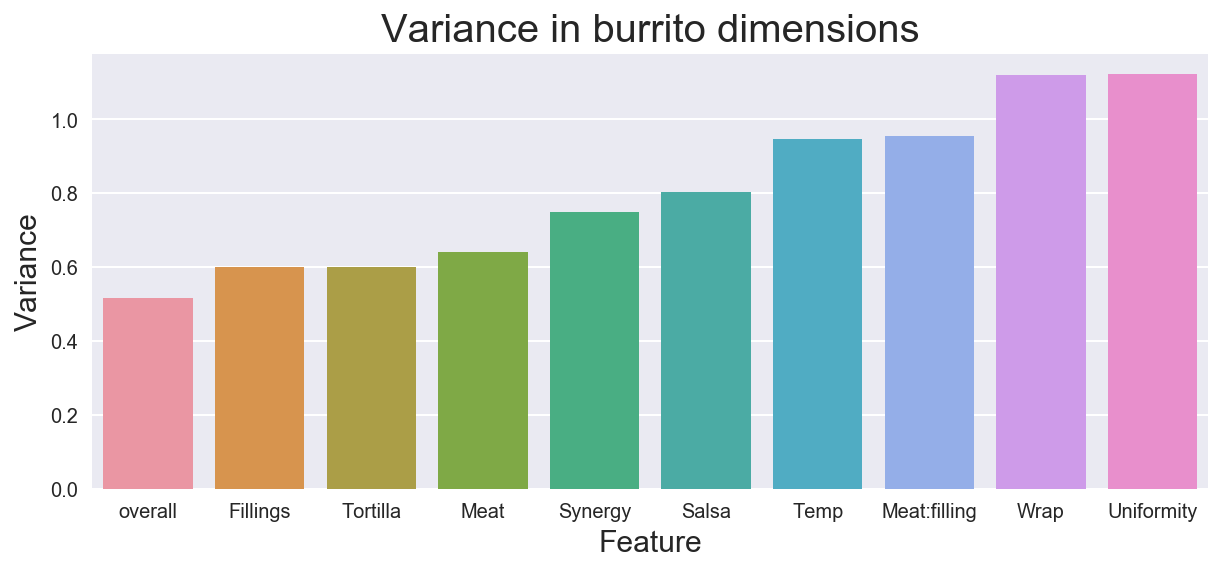

In [3]:
# Variance in features of interest
foi = ['Tortilla', 'Temp', 'Meat', 'Fillings', 'Meat:filling', 'Uniformity',
       'Salsa', 'Synergy', 'Wrap', 'overall']
var_by_feat = df[foi].var()

# Plot variance for each feature
df_plt = pd.DataFrame(var_by_feat, columns=['variance']).reset_index().rename(columns={'index':'feature'})
feature_order = df_plt.sort_values('variance')['feature']
plt.figure(figsize=(10,4))
sns.barplot(x='feature', y='variance', data=df_plt,
            order=feature_order)
plt.title('Variance in burrito dimensions', size=20)
plt.ylabel('Variance', size=15)
plt.xlabel('Feature', size=15)

# 2. How consistent are burrito features?
### 2a. For each pair of burritos (same reviewer, taco shop, burrito type), compute the difference in each metric across orders

In [4]:
# Remove rows from dataframe that don't have values in necessary features
cols_keep = np.append(foi, ['Location', 'Burrito', 'Reviewer'])
df2 = df[cols_keep].dropna(axis=0).reset_index(drop=True)

# Determine groups of ratings of the same burrito at the same restaurant by the same person
brr_groups_all = df2.groupby(['Location', 'Burrito', 'Reviewer']).groups
brr_groups = {}
for k in list(brr_groups_all.keys()):
    if len(brr_groups_all[k])>1:
        brr_groups[k] = brr_groups_all[k]
        
# Limit the dataframe to the measures we want to analyze
df_feat = df2[foi]

# Compute difference in features for first 2 observations for each group
df_feat_diffs = pd.DataFrame()
for k in brr_groups.keys():
    feature_diffs = np.abs(df_feat.loc[brr_groups[k][1]] - df_feat.loc[brr_groups[k][0]])
    df_feat_diffs = df_feat_diffs.append(feature_diffs, ignore_index=True)
    
# Compute average difference in each category
meandiff_by_feat = df_feat_diffs.mean()

# Print average difference in order
diff_sort_idx = np.argsort(meandiff_by_feat.values)
print('Diff   Feature\n----   -------')
for feat in meandiff_by_feat.keys()[diff_sort_idx]:
    print('{:.2f}  '.format(meandiff_by_feat[feat]), feat)

Diff   Feature
----   -------
0.41   Meat
0.43   Tortilla
0.49   overall
0.54   Synergy
0.59   Fillings
0.73   Meat:filling
0.80   Wrap
0.87   Salsa
0.88   Temp
1.10   Uniformity


/Users/scott/anaconda/lib/python3.6/site-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


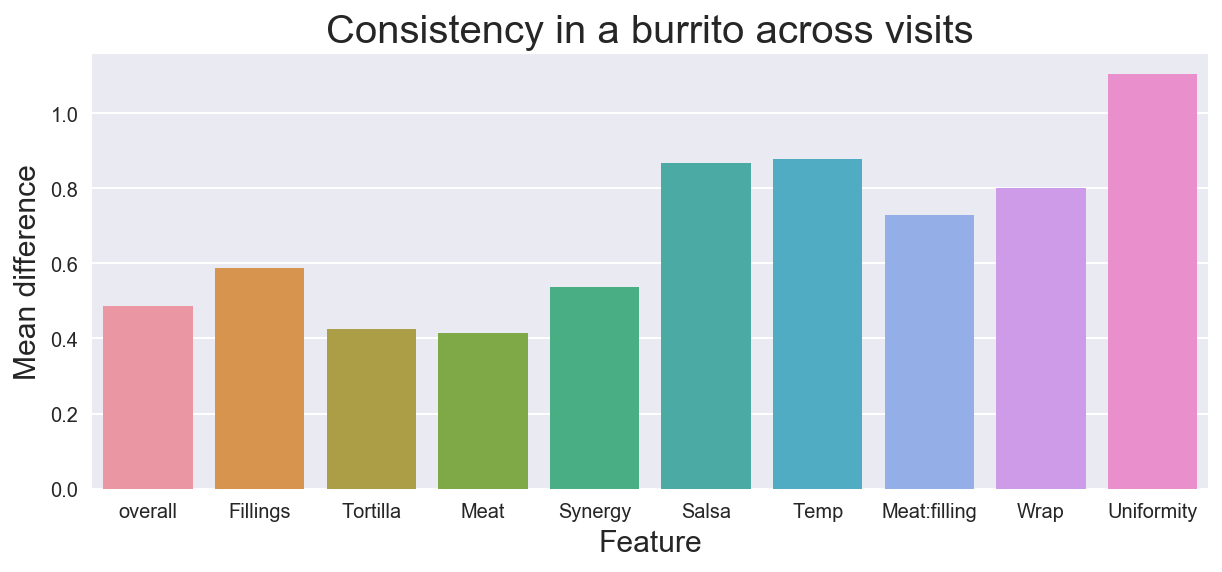

In [5]:
df_plt = pd.DataFrame(meandiff_by_feat, columns=['avgdiff']).reset_index().rename(columns={'index':'feature'})
plt.figure(figsize=(10,4))
sns.barplot(x='feature', y='avgdiff', data=df_plt,
            order=feature_order)
plt.title('Consistency in a burrito across visits', size=20)
plt.ylabel('Mean difference', size=15)
plt.xlabel('Feature', size=15)

### 2b. Compute null distribution of differences between 2 random burritos

In [6]:
np.random.seed(0)
N_sim = 1000 # Number of simulated burrito pairings

# Choose a random reviewer for each simulation
reviewers_by_repeated = [k[2] for k in brr_groups.keys()]
unique_reviewers = np.unique(reviewers_by_repeated)
sim_rating1_options = np.hstack([x[:2] for x in brr_groups.values()])
sim_rating1 = np.random.choice(sim_rating1_options, N_sim)

# For each reviewer, compute their dataframe
feat_keep = np.append(foi, 'Location')
df_by_reviewer = {}
for r in unique_reviewers:
    # Get data from 1 reviewer
    df_temp = df[df['Reviewer']==r]
    # Only look at columns of interest
    df_temp = df_temp[feat_keep]
    # Remove rows with NaN
    df_temp.dropna(axis=0, inplace=True)
    # Save reviewer dataframe
    df_by_reviewer[r] = df_temp.reset_index(drop=True)
    
# Compute feature differences for random burritos
feat_diffs_null = defaultdict(list)
for i in range(N_sim):
    # Determine reviewer
    idx_rating1 = sim_rating1[i]
    r = df2.loc[idx_rating1]['Reviewer']
    rest1 = df2.loc[idx_rating1]['Location']
    feats1 = df2.loc[idx_rating1].drop(['Location','Burrito','Reviewer'])
    
    # Choose 2 valid random burritos from that reviewer
    got_2 = False
    while not got_2:
        # Choose another random burritos
        idx_rating2 = np.random.randint(len(df_by_reviewer[r]))
        
        # Check if burritos are not from same restaurant
        rest2 = df_by_reviewer[r].loc[idx_rating2].Location
        if rest1 != rest2:
            got_2 = True
            feats2 = df_by_reviewer[r].loc[idx_rating2].drop('Location')
            
    # Compute differences for each feature
    for k in feats1.keys():
        feat_diffs_null[k].append(np.abs(feats1[k] - feats2[k]))

### 2c. Distributions of feature differences: True and null

Feature     p-value
-------     -------
Fillings      0.137  
Meat          0.001  
Meat:filling  0.058  
Salsa         0.344  
Synergy       0.009  
Temp          0.034  
Tortilla      0.007  
Uniformity    0.356  
Wrap          0.063  
overall       0.045  


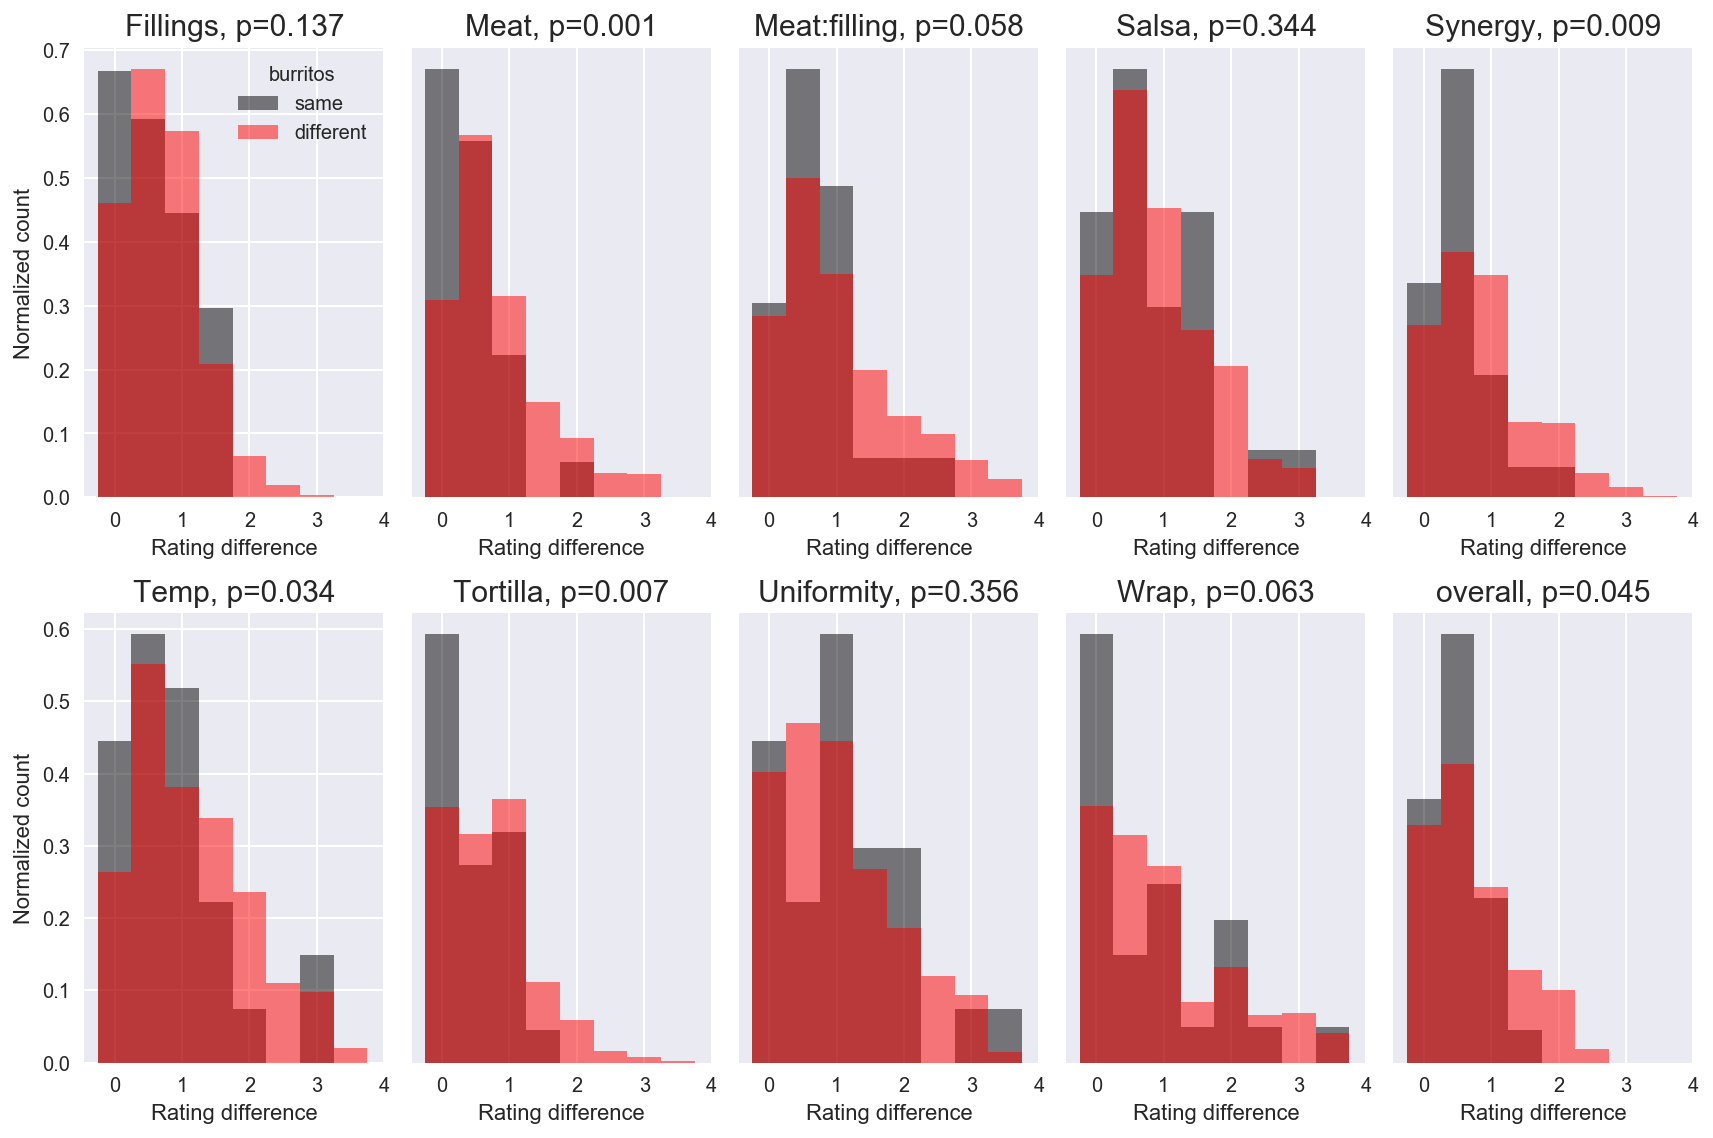

In [7]:
print('Feature     p-value\n-------     -------')
# Print stats
diff_sort_idx = np.argsort(meandiff_by_feat.values)
ps = {}
for k in df_feat_diffs.keys():
    t, ps[k] = sp.stats.mannwhitneyu(df_feat_diffs[k].values,feat_diffs_null[k])
    print('{: <14}{:.3f}  '.format(k, ps[k]))
    
plt.figure(figsize=(12,8))
for i, k in enumerate(df_feat_diffs.keys()):
    plt.subplot(2,5,i+1)
    plt.hist(df_feat_diffs[k].values,np.arange(-.25,4,.5), color='k', normed=True, alpha=.5, label='same')
    plt.hist(feat_diffs_null[k],np.arange(-.25,4,.5), color='r', normed=True, alpha=.5, label='different')
    plt.title(k+', p={:.3f}'.format(ps[k]), size=15)
    plt.xticks(np.arange(0,5,1))
    if i == 0:
        plt.legend(loc='best', title='burritos')
    if i == 0 or i == 5:
        plt.ylabel('Normalized count')
    else:
        plt.yticks([])
    plt.xlabel('Rating difference')
    plt.tight_layout()

# 3. Inter-reviewer reliability
### 3a. Determine inter-reviewer pairs

In [8]:
# Determine which burritos have been eaten at least twice
cols_keep = np.append(foi, ['Location', 'Burrito', 'Reviewer', 'Date'])
df2 = df[cols_keep].dropna(axis=0).reset_index(drop=True)
burrito_groups = df2.groupby(['Location', 'Burrito']).groups

# For each burrito group, make pairs of ratings
burrito_pairs_idxs = []
for k, idxs in burrito_groups.items():

    # Only consider burrito groups with more than 1 rating
    if len(idxs) >= 2:
        
        # Only consider burrito groups with more than 1 distinct reviewer and date
        reviewer_array = df2.loc[idxs]['Reviewer'].values
        date_array = df2.loc[idxs]['Date'].values
        if len(np.unique(reviewer_array)) > 1 and len(np.unique(date_array)) > 1:
            
            # Make new pairs as long as possible
            pairing_reviewers = np.copy(reviewer_array)
            pairing_dates = np.copy(date_array)
            pairing_idxs = np.copy(idxs)
            can_make_pair = True
            while can_make_pair:
                
                # Cannot make pair if less than 2 unique dates, 
                if len(np.unique(pairing_reviewers)) < 2 and len(np.unique(pairing_dates)) < 2:
                    can_make_pair = False

                else:
                    # Choose 1 random rating
                    rating1_i = pairing_idxs[0]
                    rating1_rev = pairing_reviewers[0]
                    rating1_date = pairing_dates[0]
                    
                    # Choose a rating that can go with this one
                    for i in range(1,len(pairing_idxs)):
                        rating2_i = pairing_idxs[i]
                        rating2_rev = pairing_reviewers[i]
                        rating2_date = pairing_dates[i]
                        if (rating1_rev != rating2_rev) and (rating1_date != rating2_date):
                            burrito_pairs_idxs.append([rating1_i, rating2_i])
                            
                            # remove those indices
                            pairing_reviewers = np.delete(pairing_reviewers, [0, i])
                            pairing_dates = np.delete(pairing_dates, [0, i])
                            pairing_idxs = np.delete(pairing_idxs, [0, i])
                            break

                        # Delete the first index if no pairings worked
                        if i == len(pairing_idxs)-1:
                            pairing_reviewers = np.delete(pairing_reviewers, 0)
                            pairing_dates = np.delete(pairing_dates, 0)
                            pairing_idxs = np.delete(pairing_idxs, 0)
                            

### 3b. Compute the difference in feature values for review pairs

In [9]:
N_pairs = len(burrito_pairs_idxs)

df_feat_diffs = pd.DataFrame()
for i in range(N_pairs):
    feature_diffs = np.abs(df_feat.loc[burrito_pairs_idxs[i][0]] - df_feat.loc[burrito_pairs_idxs[i][1]])
    df_feat_diffs = df_feat_diffs.append(feature_diffs, ignore_index=True)
    
# Compute average difference in each category
meandiff_by_feat = df_feat_diffs.mean()

# Print average difference in order
diff_sort_idx = np.argsort(meandiff_by_feat.values)
print('Diff   Feature\n----   -------')
for feat in meandiff_by_feat.keys()[diff_sort_idx]:
    print('{:.2f}  '.format(meandiff_by_feat[feat]), feat)

Diff   Feature
----   -------
0.58   overall
0.60   Meat
0.67   Fillings
0.70   Tortilla
0.78   Synergy
0.90   Salsa
0.91   Meat:filling
0.94   Wrap
0.94   Temp
1.18   Uniformity


### 3c. Compute null distribution of differences between burritos

In [10]:
np.random.seed(0)
N_sim = 1000 # Number of simulated burrito pairings

# Choose a random reviewer for each simulation
sim_rating1_options = np.hstack(burrito_pairs_idxs)
sim_rating1 = np.random.choice(sim_rating1_options, N_sim)
    
# Compute feature differences for random burritos
feat_diffs_null = defaultdict(list)
for i in range(N_sim):
    # Determine reviewer
    idx_rating1 = sim_rating1[i]
    rev1 = df2.loc[idx_rating1]['Reviewer']
    rest1 = df2.loc[idx_rating1]['Location']
    feats1 = df2.loc[idx_rating1].drop(['Location','Burrito','Reviewer','Date'])
    
    # Choose 2 valid random burritos from that reviewer
    got_2 = False
    while not got_2:
        # Choose another random burritos
        idx_rating2 = np.random.randint(len(df2))
        
        # Check if burritos are not from same restaurant
        rest2 = df2.loc[idx_rating2].Location
        rev2 = df2.loc[idx_rating2].Reviewer
        if (rest1 != rest2) and (rev1 != rev2):
            got_2 = True
            feats2 = df2.loc[idx_rating2].drop(['Location','Burrito','Reviewer','Date'])
            
    # Compute differences for each feature
    for k in feats1.keys():
        feat_diffs_null[k].append(np.abs(feats1[k] - feats2[k]))

### 3d. Distribution of feature differences: True and null

Feature     p-value
-------     -------
Fillings      0.074  
Meat          0.004  
Meat:filling  0.195  
Salsa         0.295  
Synergy       0.210  
Temp          0.195  
Tortilla      0.410  
Uniformity    0.463  
Wrap          0.495  
overall       0.061  


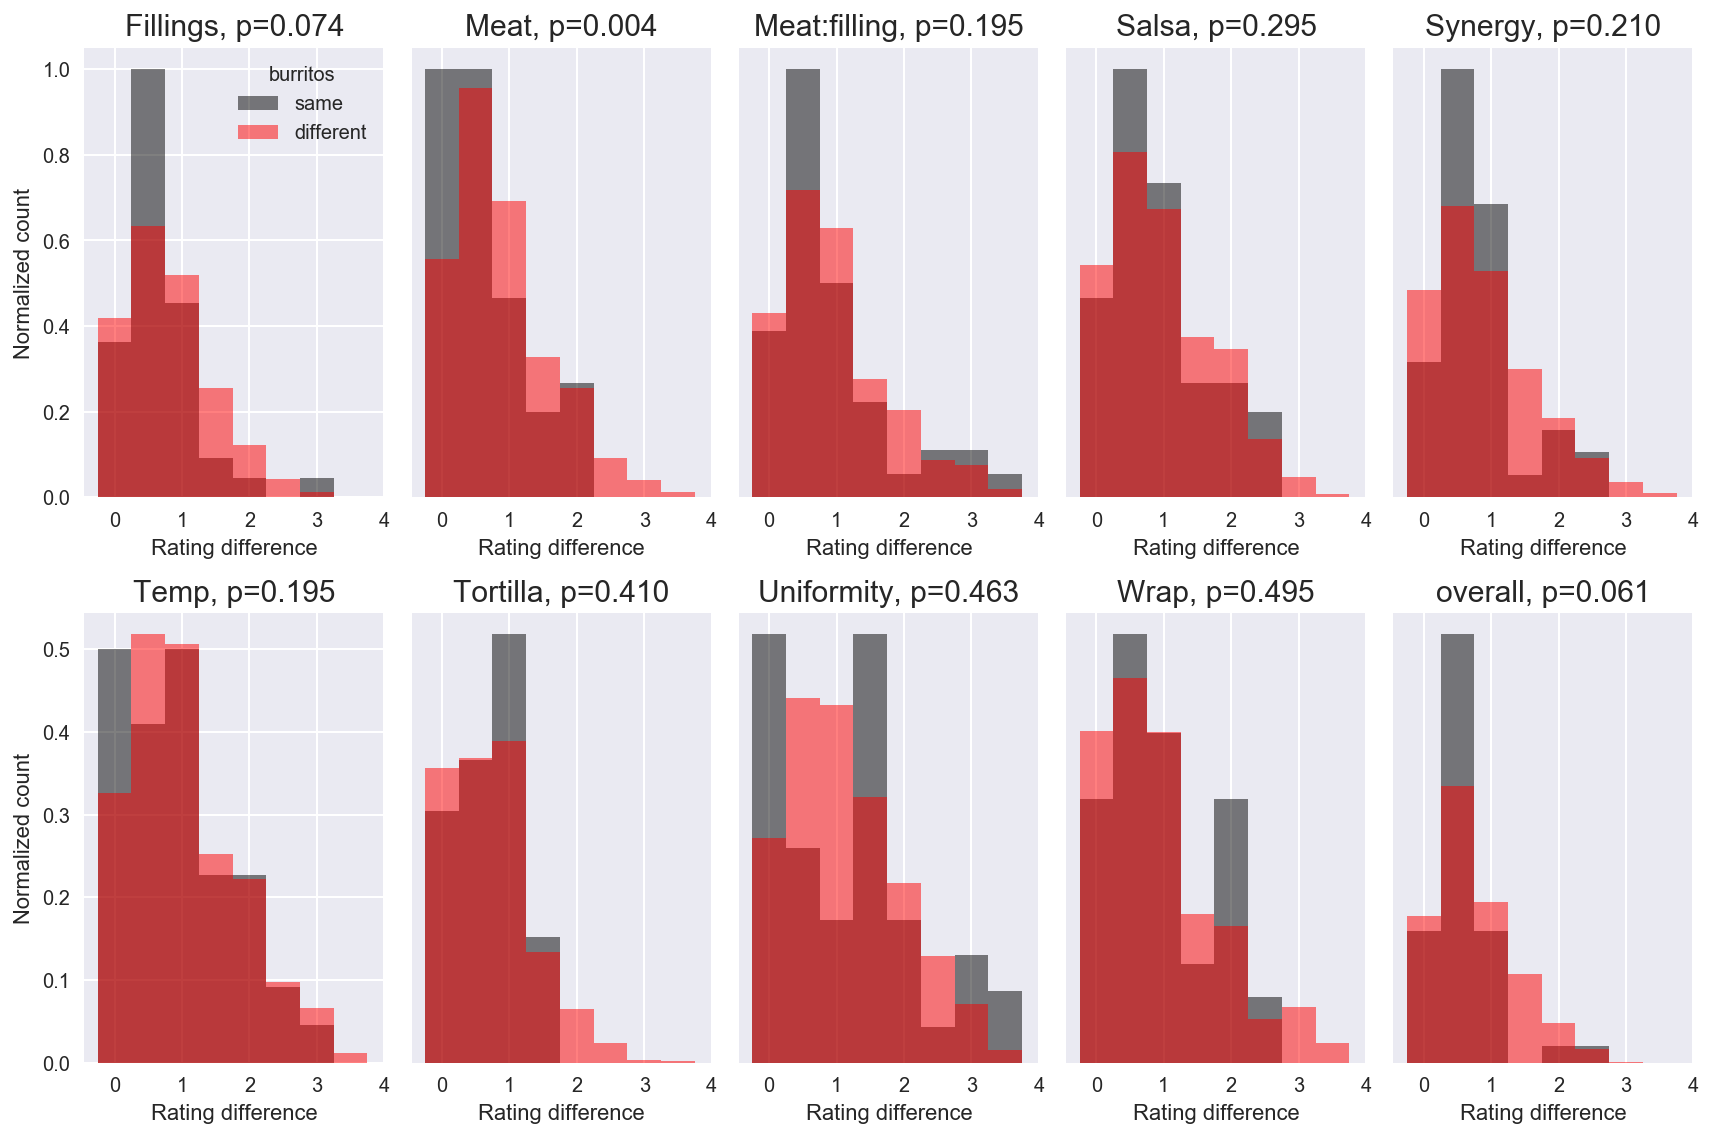

In [11]:
print('Feature     p-value\n-------     -------')
# Print stats
diff_sort_idx = np.argsort(meandiff_by_feat.values)
ps = {}
for k in df_feat_diffs.keys():
    t, ps[k] = sp.stats.mannwhitneyu(df_feat_diffs[k].values,feat_diffs_null[k])
    print('{: <14}{:.3f}  '.format(k, ps[k]))
    
plt.figure(figsize=(12,8))
for i, k in enumerate(df_feat_diffs.keys()):
    plt.subplot(2,5,i+1)
    plt.hist(df_feat_diffs[k].values,np.arange(-.25,4,.5), color='k', normed=True, alpha=.5, label='same')
    plt.hist(feat_diffs_null[k],np.arange(-.25,4,.5), color='r', normed=True, alpha=.5, label='different')
    plt.title(k+', p={:.3f}'.format(ps[k]), size=15)
    plt.xticks(np.arange(0,5,1))
    if i == 0:
        plt.legend(loc='best', title='burritos')
    if i == 0 or i == 5:
        plt.ylabel('Normalized count')
    else:
        plt.yticks([])
    plt.xlabel('Rating difference')
    plt.tight_layout()

# 4. Confidence interval for a recommendation
If we give someone a recommendation (e.g. this burrito has 4/5 meat), are we confident that the other person will have a similar feeling?

i.e. What is the probability that both ratings are within 1 point?

In [12]:
print('Feature       Probability rating within 1\n-------       ---------------------------')
    
for k in df_feat_diffs.keys():
    prob = np.mean(df_feat_diffs[k].values <= 1)
    print('{: <14}{:.2f}  '.format(k, prob))

Feature       Probability rating within 1
-------       ---------------------------
Fillings      0.89  
Meat          0.84  
Meat:filling  0.77  
Salsa         0.75  
Synergy       0.86  
Temp          0.70  
Tortilla      0.84  
Uniformity    0.50  
Wrap          0.68  
overall       0.93  
